In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
BASE_DIR = "gdrive/MyDrive/Capstone/Dataset"

In [ ]:
!ls "gdrive/MyDrive/Capstone/Dataset"

Dermatofibroma	Jerawat  Kurap	Kusta  Kutil  Panu  Sehat


In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!rm -rf 'Dataset'

In [ ]:
import splitfolders
import os

os.makedirs('Dataset')

In [ ]:
input = BASE_DIR
splitfolders.ratio(input, output = "Dataset",seed = 42,ratio = (.7,.2,.1))

Copying files: 1627 files [00:10, 149.45 files/s]


In [ ]:
TRAINING_DIR = 'Dataset/train'
VALIDATION_DIR = 'Dataset/val'
TEST_DIR = 'Dataset/test'

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 32,
                                                      class_mode = 'categorical',
                                                      target_size = (300, 300))



validation_datagen = ImageDataGenerator(rescale = 1./255.,
                                        rotation_range = 40,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        fill_mode = 'nearest')


validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 16,
                                                                class_mode = 'categorical',
                                                                shuffle=False,
                                                                target_size = (300, 300))


test_datagen = ImageDataGenerator(rescale = 1./255.,
                                        rotation_range = 40,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        fill_mode = 'nearest')


test_generator = test_datagen.flow_from_directory(directory = TEST_DIR,
                                                                batch_size = 16,
                                                                class_mode = 'categorical',
                                                                target_size = (300, 300))

Found 1110 images belonging to 7 classes.
Found 321 images belonging to 7 classes.
Found 160 images belonging to 7 classes.


In [ ]:
labels = list(train_generator.class_indices.keys())
#['Dermatofibroma',	'Jerawat', 'Kurap (1)',	'Kusta', 'Kutil', 'Panu', 'Sehat']
print(labels)

['Dermatofibroma', 'Jerawat', 'Kurap', 'Kusta', 'Kutil', 'Panu', 'Sehat']


In [ ]:
model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(24, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(256, activation='relu'),
        #tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
])

#learning_rate=0.0001
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3),
                                                include_top=False,
                                                weights='imagenet')

In [ ]:
base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(512,activation='relu')(x)
outputs = tf.keras.layers.Dense(7,activation='softmax')(x)
model = tf.keras.Model(inputs = base_model.input, outputs = outputs)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
35/35 [==============================] - 98s 2s/step - loss: 1.0553 - accuracy: 0.6234 - val_loss: 0.5821 - val_accuracy: 0.7913
Epoch 2/15
35/35 [==============================] - 42s 1s/step - loss: 0.3492 - accuracy: 0.8919 - val_loss: 0.4143 - val_accuracy: 0.8785
Epoch 3/15
35/35 [==============================] - 41s 1s/step - loss: 0.2198 - accuracy: 0.9351 - val_loss: 0.3092 - val_accuracy: 0.9159
Epoch 4/15
35/35 [==============================] - 42s 1s/step - loss: 0.1362 - accuracy: 0.9586 - val_loss: 0.2349 - val_accuracy: 0.9408
Epoch 5/15
35/35 [==============================] - 41s 1s/step - loss: 0.0719 - accuracy: 0.9766 - val_loss: 0.1825 - val_accuracy: 0.9408
Epoch 6/15
35/35 [==============================] - 43s 1s/step - loss: 0.0806 - accuracy: 0.9721 - val_loss: 0.2729 - val_accuracy: 0.9283
Epoch 7/15
35/35 [==============================] - 43s 1s/step - loss: 0.0864 - accuracy: 0.9730 - val_loss: 0.2805 - val_accuracy: 0.9159
Epoch 8/15
35/35 [==

21/21 [==============================] - 10s 400ms/step


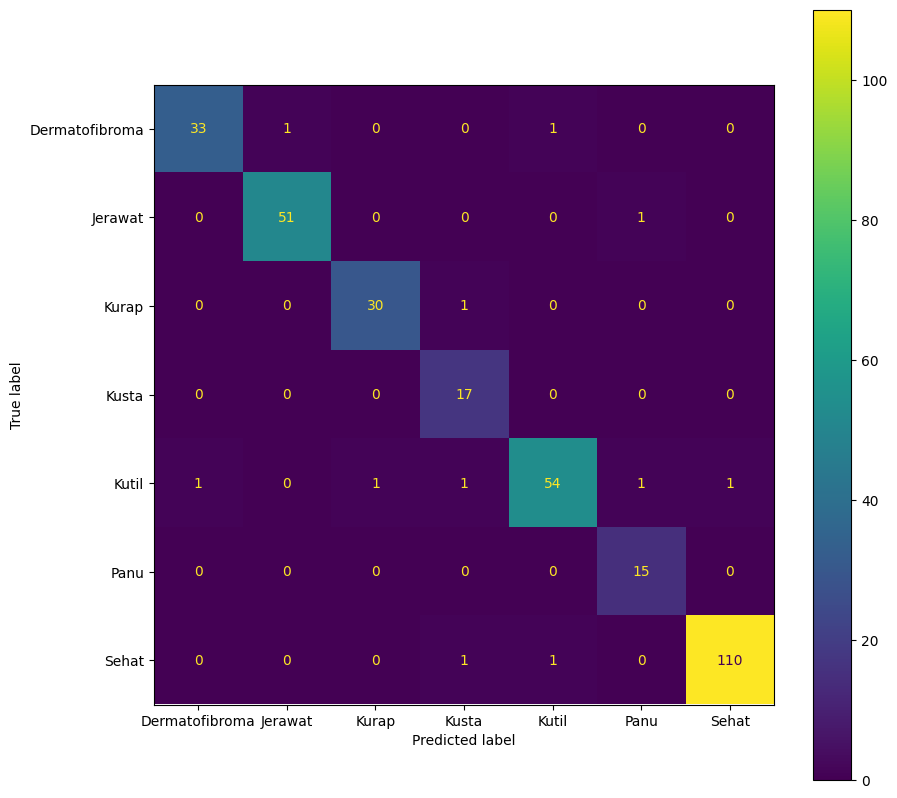

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_probs = model.predict(validation_generator)

#Convert prediction probabilities into integers
y_preds = y_probs.argmax(axis=1)

cm=confusion_matrix(y_preds,validation_generator.classes)
#Plot
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

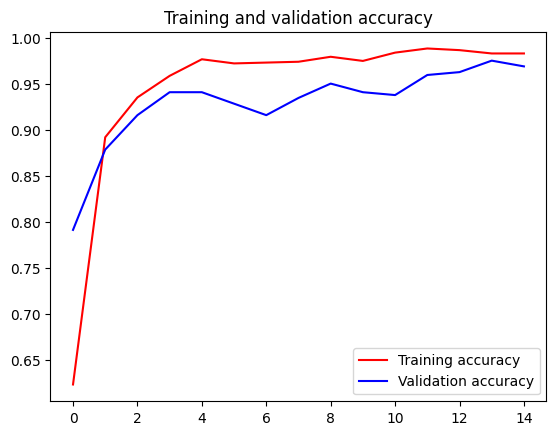

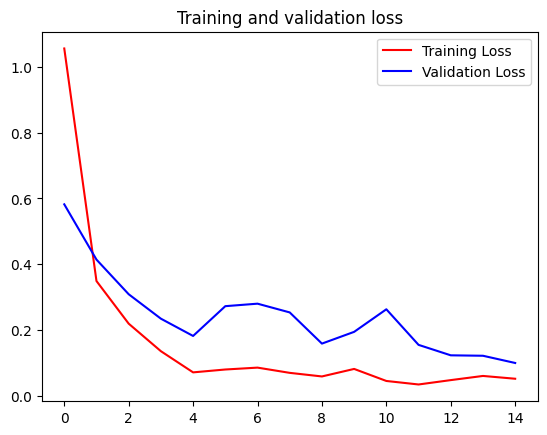

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
#epochs = np.arange(100)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_192 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_192[0][0]']             
 Normalization)                 )                                                           

In [ ]:
model_name = 'Skinease_6.h5'

model.save(model_name)

In [ ]:
#model_path = '/content/gdrive/MyDrive/Capstone/Skinease_5.h5'

#model.save(model_path)

In [ ]:
from google.colab import files
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>